## Run this script on a GPU

In [155]:
import jax
print("jax version:", jax.__version__)
print("Devices:", jax.devices())

jax version: 0.4.25
Devices: [cuda(id=0)]


In [156]:
import pandas as pd

df = pd.read_csv("data/df_indi_works.csv", index_col=0)
#df = pd.read_csv("data/df_indi_works_clean_gdp.csv", index_col=0)

print(len(df))

regions = pd.read_csv('data/ENS - Cultural Index - Countries Databases - region_level.csv')
regions = regions[regions['level'] == 2]
regions = set(regions['region_name'])
df = df[df['region_name'].isin(regions)]
df["century"] = df["decade"].round(-2)
df.head(n=10)
max(df.decade)

570881


1880

,individual_wikidata_id,decade,individual_name,score,region_code,region_name,count_works,century,count
2,Q202809,1840,Frederick Coombs,12,re_united_kingdom,United Kingdom,0.0,1800,0.0
4,Q4350107,1820,Vassili Perevoštšikov,4,re_eastern_europe,Eastern Europe,0.0,1800,0.0
5,Q4350107,1820,Vassili Perevoštšikov,4,re_slav_world,Slav world,0.0,1800,0.0
8,Q1028749,1720,Christian Friedrich Zincke,37,re_united_kingdom,United Kingdom,22.0,1700,22.0
12,Q2822993,1140,Achard of Saint-Victor,46,re_united_kingdom,United Kingdom,0.0,1100,0.0
...,...,...,...,...,...,...,...,...,...
570870,Q5549197,1870,Michael Anagnos,14,re_eastern_europe,Eastern Europe,0.0,1900,0.0
570874,Q55191347,1770,Jean-Baptiste Daubanton,1,re_france,France,0.0,1800,0.0
570876,Q43136014,1880,Alexandre Nicolaievich Roussoff,12,re_eastern_europe,Eastern Europe,0.0,1900,0.0
570877,Q43136014,1880,Alexandre Nicolaievich Roussoff,12,re_slav_world,Slav world,0.0,1900,0.0


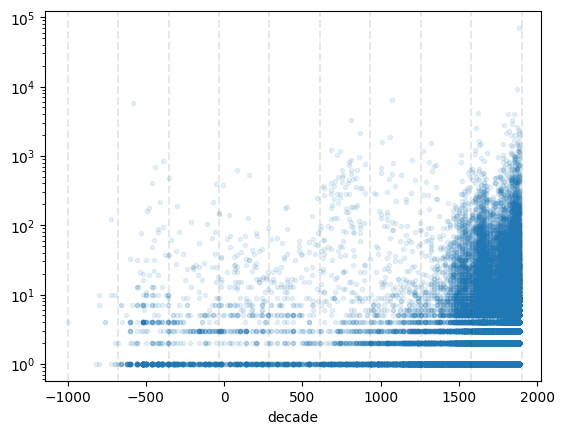

In [157]:
import matplotlib.pyplot as plt
import numpy as np

num_knots = 10
knots = np.linspace(df["century"].min(), df["century"].max(), num_knots)

fig, ax = plt.subplots()
(df.groupby(["decade", "individual_wikidata_id"])["count_works"].sum() + 1).droplevel(
    level="individual_wikidata_id").plot(style=".", alpha=0.1, logy=True, ax=ax)

for knot in knots:
    ax.axvline(knot, color="0.1", alpha=0.1, ls="--")

In [158]:
df['count'] = df['count_works']
df_m = df.copy()
df_m = df_m[df_m['count'].isin({0, 1, 2})] # Not more ?
df_m['y'] = df_m['count'].map({0: 0, 1: 0, 2: 1})
df_m


,individual_wikidata_id,decade,individual_name,score,region_code,region_name,count_works,century,count,y
2,Q202809,1840,Frederick Coombs,12,re_united_kingdom,United Kingdom,0.0,1800,0.0,0
4,Q4350107,1820,Vassili Perevoštšikov,4,re_eastern_europe,Eastern Europe,0.0,1800,0.0,0
5,Q4350107,1820,Vassili Perevoštšikov,4,re_slav_world,Slav world,0.0,1800,0.0,0
12,Q2822993,1140,Achard of Saint-Victor,46,re_united_kingdom,United Kingdom,0.0,1100,0.0,0
16,Q105607234,1820,Angelo Dalbon,4,re_italy,Italy,0.0,1800,0.0,0
...,...,...,...,...,...,...,...,...,...,...
570870,Q5549197,1870,Michael Anagnos,14,re_eastern_europe,Eastern Europe,0.0,1900,0.0,0
570874,Q55191347,1770,Jean-Baptiste Daubanton,1,re_france,France,0.0,1800,0.0,0
570876,Q43136014,1880,Alexandre Nicolaievich Roussoff,12,re_eastern_europe,Eastern Europe,0.0,1900,0.0,0
570877,Q43136014,1880,Alexandre Nicolaievich Roussoff,12,re_slav_world,Slav world,0.0,1900,0.0,0


Plot the global probability of observing a producer twice in the dataset, i.e. $p(n_{\text{obs}} = 2)$:

## Varying Splines Analysis on Regions

In [159]:
import bambi as bmb
import arviz as az

iknots = knots[1:-1]

print(iknots)

[-677.77777778 -355.55555556  -33.33333333  288.88888889  611.11111111
  933.33333333 1255.55555556 1577.77777778]


In [26]:
import bambi as bmb
import arviz as az

iknots = knots[1:-1]

print(iknots)
"""
sample = df_m

df_m[['decade', 'y']].sample(10)

priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sigma=2.5),
    "bs(decade, knots = iknots, intercept = True)|region_name": bmb.Prior(
        "Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=2.5))
}

m_splines_vs = bmb.Model(
    'y ~ 1 + (bs(decade, knots=iknots, intercept=True)|region_name)', 
    sample, family='bernoulli', priors=priors)
m_splines_vs"""

#  Global Spline Analysis with Varying Intercepts for Region

sample = df_m.copy()
sample = sample.sample(10000, random_state=42)

priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sigma=5),
    "common": bmb.Prior("Normal", mu=0, sigma=5),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=5))
}

m_splines_vi = bmb.Model(
    'y ~ bs(decade, knots=iknots, intercept=True) + (1|region_name)', 
    sample[['decade','region_name', 'y']], family='bernoulli', priors=priors)



[-677.77777778 -355.55555556  -33.33333333  288.88888889  611.11111111
  933.33333333 1255.55555556 1577.77777778]


In [27]:
sample[['decade','region_name', 'y']]

,decade,region_name,y
56653,1260,United Kingdom,0
534566,1810,German world,0
443629,1720,Japan,0
339969,1690,Central Europe,0
112053,-560,Balkans,0
...,...,...,...
479308,1880,France,0
101184,1860,German world,0
394236,1880,Italy,0
243302,1880,France,1


In [28]:
m_splines_vi

       Formula: y ~ bs(decade, knots=iknots, intercept=True) + (1|region_name)
        Family: bernoulli
          Link: p = logit
  Observations: 10000
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 5.0)
            bs(decade, knots=iknots, intercept=True) ~ Normal(mu: 0.0, sigma: 5.0)
        
        Group-level effects
            1|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 5.0))

In [31]:
p_splines_vs = m_splines_vi.fit(
    draws=1000, chains=4, inference_method='nuts_numpyro')  # important to run faster and sample more efficiently

Modeling the probability that y==1
Compiling...
2024-02-28 11:31:25.323460: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
/home/charles/.venv/lib/python3.10/site-packages/pymc/sampling/jax.py:687: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
Compilation time = 0:00:21.134156
Sampling...
sample: 100%|██████████| 2000/2000 [00:43<00:00, 45.69it/s, 63 st

In [33]:
az.summary(p_splines_vs)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-3.696,1.592,-6.512,-0.668,0.050,0.036,995.0,1479.0,1.0
"bs(decade, knots=iknots, intercept=True)[0]",-1.871,3.859,-9.279,5.095,0.065,0.057,3774.0,2656.0,1.0
"bs(decade, knots=iknots, intercept=True)[1]",-1.617,3.553,-8.289,4.923,0.062,0.053,3312.0,2880.0,1.0
"bs(decade, knots=iknots, intercept=True)[2]",2.325,2.515,-2.334,7.137,0.062,0.044,1660.0,2167.0,1.0
"bs(decade, knots=iknots, intercept=True)[3]",1.210,2.546,-3.519,5.940,0.062,0.044,1689.0,2307.0,1.0
"bs(decade, knots=iknots, intercept=True)[4]",-4.037,2.988,-9.783,1.446,0.059,0.044,2620.0,2897.0,1.0
"bs(decade, knots=iknots, intercept=True)[5]",2.050,2.384,-2.478,6.398,0.060,0.043,1567.0,2184.0,1.0
"bs(decade, knots=iknots, intercept=True)[6]",-0.301,2.381,-4.778,4.150,0.055,0.039,1852.0,2244.0,1.0
"bs(decade, knots=iknots, intercept=True)[7]",-0.378,2.065,-4.298,3.455,0.055,0.039,1405.0,1968.0,1.0
"bs(decade, knots=iknots, intercept=True)[8]",1.282,1.720,-2.056,4.432,0.051,0.036,1140.0,1861.0,1.0


Plot the regional probability of observing a producer twice in the dataset over time, i.e. 𝑝(𝑛obs=2):

In [160]:
def plot_knots(knots, ax):
    for knot in knots:
        ax.axvline(knot, color="0.1", alpha=0.4)
    return ax

def plot_predictions(data, idata, model, region=None, ax=None, plot_knot_lines=True, color="C0"):
    if ax is None:
        fig, ax = plt.subplots()
    
    new_data = {}
    if region is not None:
        data = data[data["region_name"] == region]
        new_data["region_name"] = [region] * 500
    new_data["decade"] = np.linspace(data["decade"].min(), data["decade"].max(), num=500)
    new_data = pd.DataFrame(new_data)

    model.predict(idata, data=new_data)

    posterior_stacked = az.extract(idata)
    # Extract these predictions
    y_hat = posterior_stacked["y_mean"]

    # Compute the mean of the predictions, plotted as a single line.
    y_hat_mean = y_hat.mean("sample")

    # Compute 94% credible intervals for the predictions, plotted as bands
    hdi_data = np.quantile(y_hat, [0.11, 0.89], axis=1)

    # Plot predicted line
    ax.plot(new_data["decade"], y_hat_mean, color=color, label=region)

    # Plot credibility bands
    ax.fill_between(new_data["decade"], hdi_data[0], hdi_data[1], alpha=0.4, color=color)

    # Add knots
    if plot_knot_lines:
        plot_knots(knots, ax)
    ax.set(xlabel="time", ylabel="p(n_obs=2)")

[Text(0.5, 0, 'time'), Text(0, 0.5, 'p(n_obs=2)')]

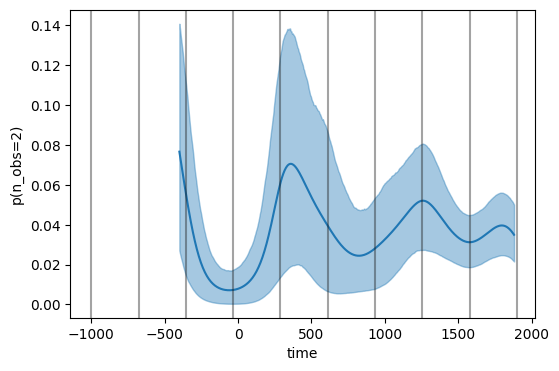

In [161]:
region = 'Chinese world'

fig, ax = plt.subplots(figsize=(6, 4))  

new_data = {}
if region is not None:
    sample_fil = sample[sample["region_name"] == region]
    new_data["region_name"] = [region] * 500


new_data["decade"] = np.linspace(sample_fil["decade"].min(), sample_fil["decade"].max(), num=500)
new_data = pd.DataFrame(new_data)
m_splines_vi.predict(p_splines_vs, data=new_data) # it predicts y = 1 based on the region_name and the decade

posterior_stacked = az.extract(p_splines_vs)

# Extract these predictions
y_hat = posterior_stacked["y_mean"] # probalility this is equal to 2

# Compute the mean of the predictions, plotted as a single line.
y_hat_mean = y_hat.mean("sample")

# Compute 94% credible intervals for the predictions, plotted as bands
hdi_data = np.quantile(y_hat, [0.11, 0.89], axis=1)

# Plot predicted line
color="C0"
ax.plot(new_data["decade"], y_hat_mean, color=color, label=region)

# Plot credibility bands
ax.fill_between(new_data["decade"], hdi_data[0], hdi_data[1], alpha=0.4, color=color)


plot_knots(knots, ax)
ax.set(xlabel="time", ylabel="p(n_obs=2)")


In [32]:
# probabiloty of y=1 based on the trained binomial model

In [68]:
# Plot estimations

In [103]:
sample

m_splines_vi # model
p_splines_vs # idata

region = 'Chinese world'
color="C0"
plot_knot_lines = True
logy=False

#fig, ax = plt.subplots()

new_data = {}
data = sample[sample["region_name"] == region]
obs_data = sample[sample["region_name"] == region]
new_data["decade"] = data["decade"].values 
new_data["region_name"] = [region] * len(data["decade"].values)
new_data = pd.DataFrame(new_data)


m_splines_vi.predict(p_splines_vs, data=new_data)

posterior_stacked = az.extract(p_splines_vs)

p = posterior_stacked["y_mean"].values
l = (2 * p) / (1 - p)
f0 = (1 / (l + (l**2) / 2))

decades = np.array(sorted(data["decade"].unique()))

N_est = np.zeros((len(decades), f0.shape[1]))
unseen = np.zeros((len(decades), f0.shape[1]))

n_obs_di = sample.loc[sample["decade"] == 1200, "individual_wikidata_id"].nunique()
mask = (new_data["decade"] == 1200).astype(int).values[:, None]


f0_di = (f0 * mask).sum(0)

S_di = n_obs_di + f0_di

N_est[i] = S_di

(58, 4000)

array([5., 5., 5., ..., 5., 5., 5.])

In [148]:
def plot_estimations(data, idata, model, region=None, ax=None, logy=False, 
                     plot_knot_lines=True, color="C0"):
    if ax is None:
        fig, ax = plt.subplots()
    
    new_data = {}
    data = data[data["region_name"] == region]
    data = data[data["region_name"] == region]   
    
    new_data["decade"] = data["decade"].values 
    new_data["region_name"] = [region] * len(data["decade"].values)
    
    new_data = pd.DataFrame(new_data)
    
    model.predict(idata, data=new_data) # we predict based on decade!

    posterior_stacked = az.extract(idata)
    # Extract these predictions
    p = posterior_stacked["y_mean"].values
    l = (2 * p) / (1 - p)
    f0 = (1 / (l + (l**2) / 2))

    decades = np.array(sorted(data["decade"].unique()))
    
    N_est = np.zeros((len(decades), f0.shape[1]))
    unseen = np.zeros((len(decades), f0.shape[1]))
    
    for i, decade in enumerate(decades):
        n_obs_di = data.loc[data["decade"] == decade, "individual_wikidata_id"].nunique()
        mask = (new_data["decade"] == decade).astype(int).values[:, None]
        f0_di = (f0 * mask).sum(0)
        S_di = n_obs_di + f0_di # original n + unseen occurences for eveery decade
        N_est[i] = S_di
        unseen[i] = f0_di

    # Compute 94% credible intervals for the predictions, plotted as bands
    hdi_data = np.quantile(N_est, [0.11, 0.89], axis=1) # because N_est is a distribution

    # Plot predicted line
    ax.plot(decades, N_est.mean(1), color="grey", label=region) # the mean is the result we give of the paper
    
    data[data["region_name"] == region].groupby("decade")["individual_wikidata_id"].count().plot(
        ax=ax, ls="--", color="red")
    
    # Plot credibility bands
    ax.fill_between(decades, hdi_data[0], hdi_data[1], alpha=0.4, color=color)

    # Add knots
    if plot_knot_lines:
        plot_knots(knots, ax)
    ax.set(xlabel="time", ylabel="Estimated diversity")
    if logy:
        ax.set_yscale("log")
    
    return unseen, N_est, hdi_data, decades

(array([[  5.10906221,   4.11423841,   5.40424074, ...,   5.91605461,
           6.75489692,   7.02195762],
        [  4.23048847,   4.84440464,   4.58948955, ...,   5.15843714,
           5.37871364,   7.45458728],
        [  8.60118398,  10.14420235,   9.19838596, ...,  10.09046873,
          10.50711563,  14.7646874 ],
        ...,
        [624.17781235, 356.36972523, 463.95366093, ..., 578.17834989,
         480.84330734, 514.7762669 ],
        [452.01551031, 258.28420733, 333.67833043, ..., 397.98102509,
         353.8666185 , 331.32478948],
        [622.9463643 , 355.50708014, 455.86070299, ..., 515.74115731,
         495.08670233, 397.8843665 ]]),
 array([[  6.10906221,   5.11423841,   6.40424074, ...,   6.91605461,
           7.75489692,   8.02195762],
        [  5.23048847,   5.84440464,   5.58948955, ...,   6.15843714,
           6.37871364,   8.45458728],
        [ 10.60118398,  12.14420235,  11.19838596, ...,  12.09046873,
          12.50711563,  16.7646874 ],
        ...,


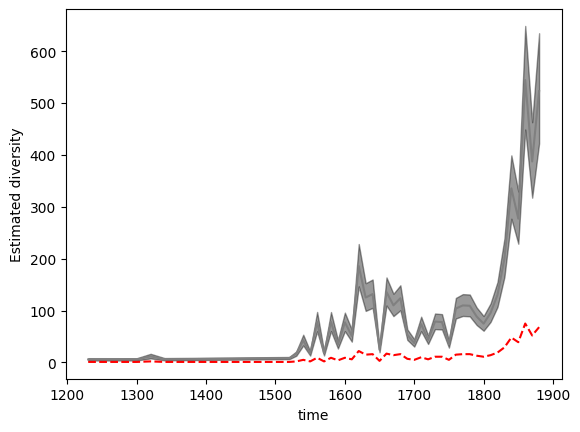

In [145]:
plot_estimations(
    sample, p_splines_vs, m_splines_vi, "Low countries", color="k", plot_knot_lines=False, logy =False)

Text(0.5, 0.01, 'time')

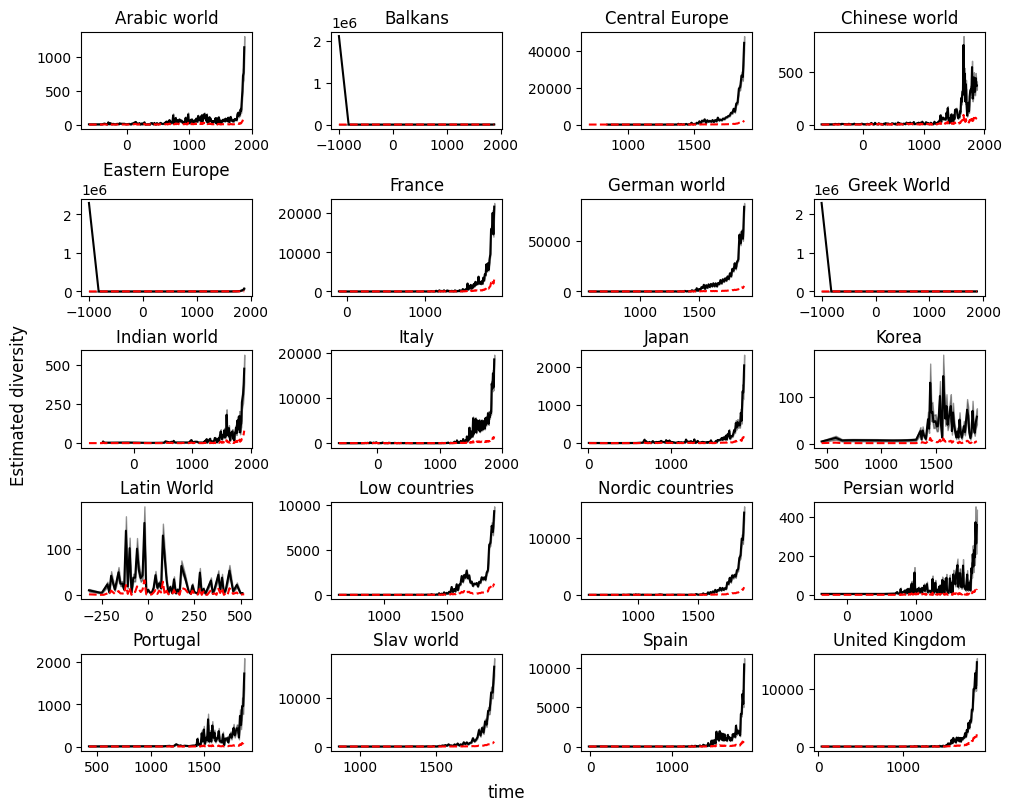

In [ ]:
fig, axes = plt.subplots(ncols=4, nrows=5, figsize=(10, 8), constrained_layout=True)
axes = axes.flatten()

results = {}
for i, region in enumerate(sorted(df_m["region_name"].unique())):
    f0, N_est, hdi, decades = plot_estimations(
        sample, df, p_splines_vs, m_splines_vi, region, ax=axes[i], color="k", plot_knot_lines=False);
    axes[i].set(title=region, xlabel="", ylabel="")
    results[region] = f0, N_est, hdi, decades

fig.supylabel('Estimated diversity')
fig.supxlabel('time')


In [ ]:
fig.savefig('results/estimated_diversity_per_region.png', dpi=300)

In [146]:
def plot_trend(decades, N_est, hdi_data, color="C0", label=None, ax=None, logy=False, figsize=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    # Plot predicted line
    ax.plot(decades, N_est.mean(1), color=color, label=label)

    # Plot credibility bands
    ax.fill_between(decades, hdi_data[0], hdi_data[1], alpha=0.4, color=color)

    ax.set(xlabel="time", ylabel="Estimated diversity")
    if logy:
        ax.set_yscale("log")

    return ax

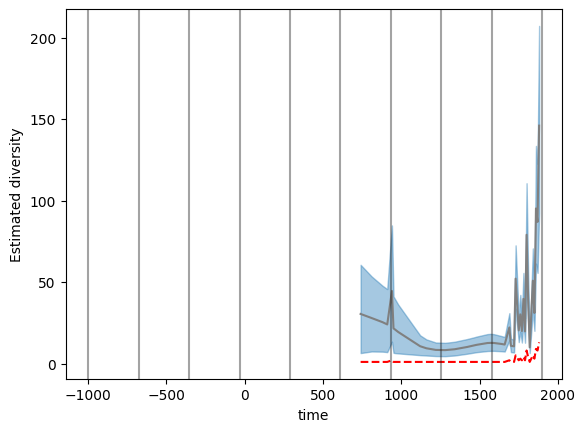

In [153]:
region = 'Japan'

f0, N_est, hdi, decades = plot_estimations(sample, p_splines_vs, m_splines_vi, region=region, ax=None, logy=False, plot_knot_lines=True, color="C0")


(1000.0, 1900.0)

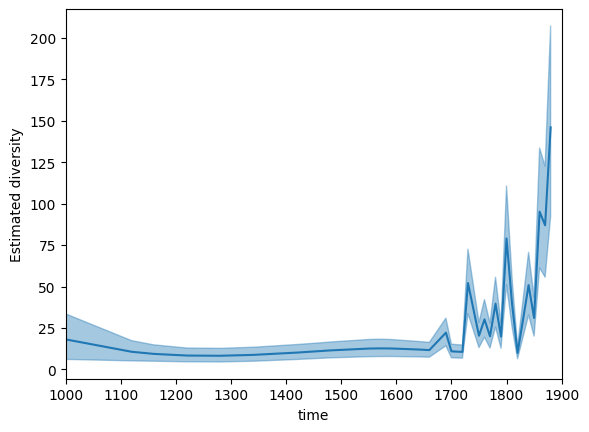

In [154]:

ax = plot_trend(decades, N_est, hdi, label=region)
ax.set_xlim(1000, 1900)

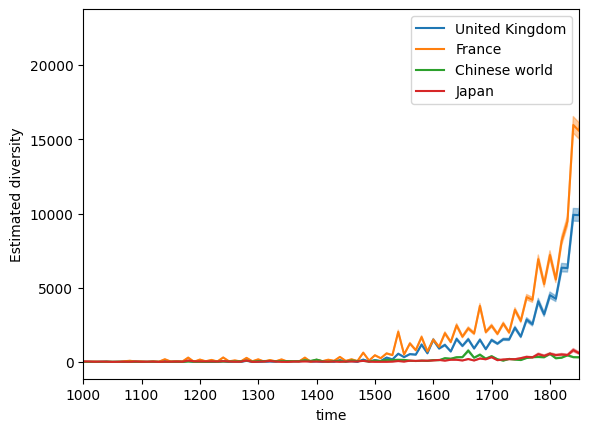

In [ ]:
regions = "United Kingdom", "France", "Chinese world", "Japan"

fig, ax = plt.subplots()
for i, region in enumerate(regions):
    f0, N_est, hdi, decades = results[region]
    ax = plot_trend(decades, N_est, hdi, color=f"C{i}", logy=False, label=region, ax=ax)
ax.set_xlim(1000, 1850)
ax.legend()

In [ ]:
import pickle

with open("regression-dump.pickle", "wb") as out:
    pickle.dump(results, out)

In [ ]:
table = []
for region in results:
    _, N_est, hdi, decades = results[region]
    N_est = N_est.mean(1)
    li, ui = hdi[0], hdi[1]
    print(N_est.shape, li.shape, ui.shape, decades.shape)
    table.append(pd.DataFrame({
        "N_est": N_est,
        "lower": li,
        "upper": ui,
        "decade": decades,
        "region": [region] * N_est.shape[0]
    }))
table = pd.concat(table)
table.head()

table.to_csv("results/estimations_charles.csv", index=False)
#table.to_csv("results/estimations.csv", index=False)
#table.to_csv("results/estimations_clean_gdp.csv", index=False)

(186,) (186,) (186,) (186,)
(137,) (137,) (137,) (137,)
(71,) (71,) (71,) (71,)
(189,) (189,) (189,) (189,)
(154,) (154,) (154,) (154,)
(113,) (113,) (113,) (113,)
(103,) (103,) (103,) (103,)
(199,) (199,) (199,) (199,)
(101,) (101,) (101,) (101,)
(166,) (166,) (166,) (166,)
(116,) (116,) (116,) (116,)
(70,) (70,) (70,) (70,)
(64,) (64,) (64,) (64,)
(71,) (71,) (71,) (71,)
(84,) (84,) (84,) (84,)
(109,) (109,) (109,) (109,)
(65,) (65,) (65,) (65,)
(57,) (57,) (57,) (57,)
(97,) (97,) (97,) (97,)
(94,) (94,) (94,) (94,)


,N_est,lower,upper,decade,region
0,4.386424,3.353913,5.531837,-610,Arabic world
1,4.906361,3.892610,6.024399,-520,Arabic world
2,5.188855,4.135945,6.329057,-400,Arabic world
3,15.920481,12.577407,19.575755,-360,Arabic world
4,5.431743,4.280787,6.679775,-330,Arabic world


<Axes: xlabel='decade'>

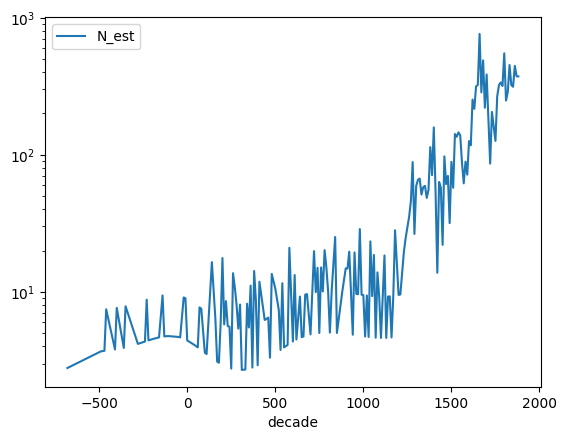

In [ ]:
test = table[table['region']=='Chinese world']
test.plot(x='decade', y ='N_est', logy=True)